In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from PIL import Image
import requests
import numpy as np
import pickle

# Import an image
img_url = "https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_2/datasets/an2i_left_angry_open.png"
example_image = Image.open(requests.get(img_url, stream=True).raw)
example_image

Before we augment an image, we must preprocess it like we have before

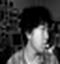

In [18]:
# Do some quick preprocessing
## Resize
example_image = example_image.resize((60, 64), Image.LANCZOS)
example_image

In [19]:
# Convert to floating point and normalize
float_image = np.array(example_image).astype(np.float32) / 255
float_image


array([[0.04313726, 0.10196079, 0.1882353 , ..., 0.20392157, 0.20784314,
        0.21176471],
       [0.01960784, 0.07843138, 0.16862746, ..., 0.20392157, 0.20784314,
        0.21176471],
       [0.        , 0.04705882, 0.14117648, ..., 0.20392157, 0.21176471,
        0.21568628],
       ...,
       [0.        , 0.        , 0.        , ..., 0.37254903, 0.1764706 ,
        0.05490196],
       [0.        , 0.        , 0.00392157, ..., 0.43137255, 0.24705882,
        0.12941177],
       [0.        , 0.        , 0.00392157, ..., 0.45490196, 0.28627452,
        0.17254902]], dtype=float32)

In [20]:
# Look at the shape
float_image.shape

(64, 60)

In addition to our regular preprocessing, the image generator requires a "batch" dimension and a "channels" dimension. RGB images already have channel dimensions, but a grayscale image must have it added.

In [21]:
# The image generator requires a "batch" dimension
# We can add that using the "expand dims" function

# Add batch dimension
reshaped_image_array = np.expand_dims(float_image, axis=0)

# For grayscale images, the "channels" dimension must be added
# Add a channel dimension for grayscale images
reshaped_image_array = np.expand_dims(reshaped_image_array, axis=-1)

# View the shape
reshaped_image_array.shape

(1, 64, 60, 1)

In [22]:
# Create an ImageDataGenerator with augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation (degrees)
    fill_mode='nearest'     # Fill mode for handling newly created pixels
)

# Create an image
augmented_image = datagen.flow(reshaped_image_array, batch_size=1).next()[0]

# View the shape of the new image
augmented_image.shape

(64, 60, 1)

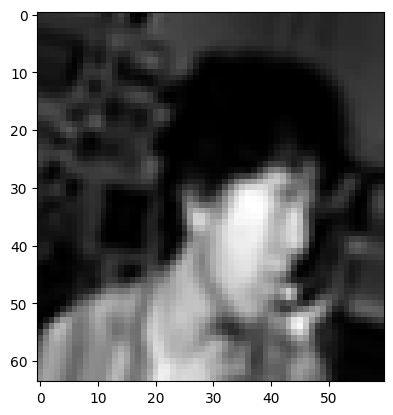

In [23]:
# Using a plotting library like matplot lib, we can view this image
# Plot the new image
# Note that we select all data from the first two dimensions, and specifically
# select the first value from the third dimension (color scale). We
# multiply by 255 to undo the normalization for plotting.

plt.imshow((augmented_image[:, :, 0]*255).astype('uint8'), cmap='gray')
plt.show()


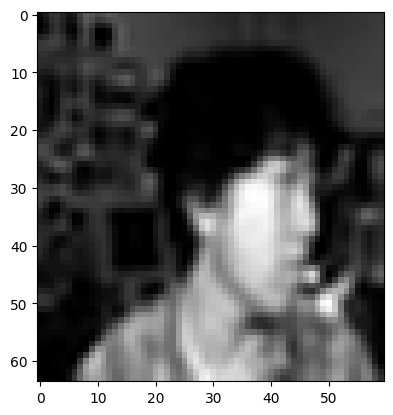

In [24]:
# Plot the original for comparison
plt.imshow((reshaped_image_array[0, :, :, 0]* 255).astype('uint8'), cmap='gray')

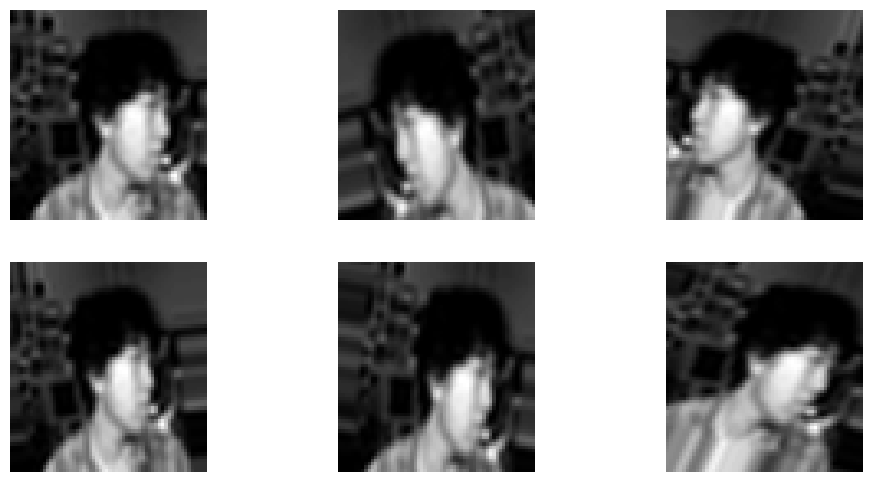

In [25]:
# We can randomly apply multiple transformations at once
# to add variety to the data
# Create an ImageDataGenerator with augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation (degrees)
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1, # Random vertical shift
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    vertical_flip=False,    # No vertical flip for face images
    fill_mode='nearest'     # Fill mode for handling newly created pixels
)


# Generate augmented images
augmented_images = []
for _ in range(5):  # Augment the image 5 times for variety
    augmented_image = datagen.flow(reshaped_image_array, batch_size=1).next()[0]
    augmented_images.append(augmented_image)

# Visualize the original and augmented images
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    if i == 0:
        plt.imshow((reshaped_image_array[0, :, :, 0]*255).astype('uint8'), cmap='gray')  # Original image
    else:
        plt.imshow((augmented_images[i - 1][:, :, 0]*255).astype('uint8'), cmap='gray')
    plt.axis('off')

plt.show()

We could also easily apply these augmentations to the entire training set to make our model more robust; to do this, we will not display all the images. Displaying the images is nice to verify your work, but it is not a necessary step.

First, we import our preprocessed data and split it into training and testing sets

In [27]:
import pickle
import io
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Import the preprocessed data
X_preprocessed_url = "https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_2/datasets/pickles/face_images_preprocessed.pkl"
y_url = "https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_2/datasets/pickles/sunglasses_y.pkl"

X = pickle.load(io.BytesIO(requests.get(X_preprocessed_url).content))
y = pickle.load(io.BytesIO(requests.get(y_url).content))

# Label encode the y data
y_encoder = LabelEncoder().fit(y)
y = y_encoder.transform(y)

# Convert values to numpy arrays
X = np.array(X)

# Split the training dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Next we build our data generator; make sure to select only parameters that will work with our data. An image of a face might appear facing either left or right, but in our data it would never appear upside down, so flipping the images vertically would not make sense!

In [33]:
# Create the image generator
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation (degrees)
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1, # Random vertical shift
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    vertical_flip=False,    # No vertical flip for face images
    fill_mode='nearest'     # Fill mode for handling newly created pixels
)

Now we can loop through the entire training set and add 5 new images based on every original image. Note that we only do this for the training dataset; this is to help our model learn to identify the original images correctly! Adding "fake" images to the testing set would skew our results.

In [34]:
# Create an empty list for both X and y augmentations

X_train_aug = []
y_train_aug = []

# Loop through each image in the training data
for i in range(len(X_train)):
    # Select the image and its y label
    img = X_train[i]
    label = y_train[i]

    # Add a channel dimension for grayscale images
    img = np.expand_dims(img, axis=-1)

    # Add the batch dimension
    img = np.expand_dims(img, axis=0)

    # Use a loop to create 5 new images
    # Append each to X_train_aug
    # For each image, use concat to add the correct label to y_train_aug
    for j in range(5):
        X_train_aug.append(datagen.flow(img, batch_size=1).next()[0])
        y_train_aug.append(label)

# Print the lengths of both augmented sets to ensure they are the same length
print(len(X_train_aug))
print(len(y_train_aug))

2495
2495
